In [1]:
import os
import random
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from sklearn.metrics import roc_auc_score, accuracy_score

In [2]:
class SignatureDataset(Dataset):
    def __init__(self, dataset_path, transform=None):
        self.dataset_path = dataset_path
        self.transform = transform

        self.genuine_path = os.path.join(dataset_path, "full_org")
        self.forged_path = os.path.join(dataset_path, "full_forg")

        valid_exts = [".png", ".jpg", ".jpeg", ".tif", ".tiff"]

        self.genuine_images = [
            f for f in os.listdir(self.genuine_path)
            if os.path.splitext(f)[1].lower() in valid_exts
        ]
        self.forged_images = [
            f for f in os.listdir(self.forged_path)
            if os.path.splitext(f)[1].lower() in valid_exts
        ]

        self.pairs = []
        self.labels = []

        # Genuine pairs (label 1)
        for i in range(len(self.genuine_images) - 1):
            self.pairs.append((self.genuine_images[i], self.genuine_images[i + 1]))
            self.labels.append(1)

        # Forged pairs (label 0)
        for i in range(len(self.genuine_images)):
            if i < len(self.forged_images):
                self.pairs.append((self.genuine_images[i], self.forged_images[i]))
                self.labels.append(0)

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img1_name, img2_name = self.pairs[idx]
        label = self.labels[idx]

        if img1_name in self.forged_images:
            img1 = Image.open(os.path.join(self.forged_path, img1_name)).convert("L")
        else:
            img1 = Image.open(os.path.join(self.genuine_path, img1_name)).convert("L")

        if img2_name in self.forged_images:
            img2 = Image.open(os.path.join(self.forged_path, img2_name)).convert("L")
        else:
            img2 = Image.open(os.path.join(self.genuine_path, img2_name)).convert("L")

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, torch.tensor([label], dtype=torch.float32)

In [3]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        self.fc = nn.Sequential(
            nn.Linear(128 * 16 * 25, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 128)
        )

    def forward_once(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def forward(self, x1, x2):
        output1 = self.forward_once(x1)
        output2 = self.forward_once(x2)
        return output1, output2

In [4]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss = torch.mean(
            (label) * torch.pow(euclidean_distance, 2) +
            (1 - label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        )
        return loss

In [5]:
def evaluate(model, dataloader, device, threshold=1.0):
    model.eval()
    all_labels = []
    all_preds = []
    distances = []

    with torch.no_grad():
        for img1, img2, label in dataloader:
            img1, img2 = img1.to(device), img2.to(device)
            out1, out2 = model(img1, img2)
            dist = F.pairwise_distance(out1, out2)

            pred = (dist < threshold).float()

            all_labels.extend(label.cpu().numpy())
            all_preds.extend(pred.cpu().numpy())
            distances.extend(-dist.cpu().numpy())  # invert for AUC

    acc = accuracy_score(all_labels, np.round(all_preds))
    auc = roc_auc_score(all_labels, distances)
    return acc, auc

In [6]:
def train_model(dataset_path, num_epochs=20, batch_size=16, lr=0.0005, device=None):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    transform = transforms.Compose([
        transforms.Resize((155, 220)),
        transforms.ToTensor()
    ])

    dataset = SignatureDataset(dataset_path, transform=transform)

    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = SiameseNetwork().to(device)
    criterion = ContrastiveLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    checkpoint_dir = "checkpoints"
    os.makedirs(checkpoint_dir, exist_ok=True)

    best_auc = 0.0
    history = {"train_loss": [], "train_acc": [], "train_auc": [], "test_acc": [], "test_auc": []}

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for img1, img2, label in loop:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)

            optimizer.zero_grad()
            out1, out2 = model(img1, img2)
            loss = criterion(out1, out2, label)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        avg_loss = epoch_loss / len(train_loader)

        train_acc, train_auc = evaluate(model, train_loader, device)
        test_acc, test_auc = evaluate(model, test_loader, device)

        history["train_loss"].append(avg_loss)
        history["train_acc"].append(train_acc)
        history["train_auc"].append(train_auc)
        history["test_acc"].append(test_acc)
        history["test_auc"].append(test_auc)

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"- Loss: {avg_loss:.4f} "
              f"- Train Acc: {train_acc:.4f}, Train AUC: {train_auc:.4f} "
              f"- Test Acc: {test_acc:.4f}, Test AUC: {test_auc:.4f}")

        torch.save(model.state_dict(), os.path.join(checkpoint_dir, f"siamese_epoch{epoch+1}.pth"))
        if test_auc > best_auc:
            best_auc = test_auc
            torch.save(model.state_dict(), os.path.join(checkpoint_dir, "siamese_best.pth"))
            print(f"✅ Saved best model at epoch {epoch+1} with Test AUC: {best_auc:.4f}")

    # -------------------------------
    # Plot metrics
    # -------------------------------
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(18,5))

    # Loss
    plt.subplot(1,3,1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    # Accuracy
    plt.subplot(1,3,2)
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["test_acc"], label="Test Acc")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    # AUC
    plt.subplot(1,3,3)
    plt.plot(epochs, history["train_auc"], label="Train AUC")
    plt.plot(epochs, history["test_auc"], label="Test AUC")
    plt.title("AUC")
    plt.xlabel("Epoch")
    plt.ylabel("AUC")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

Epoch 1/20: 100%|██████████| 132/132 [01:54<00:00,  1.15it/s, loss=1.17] 


Epoch [1/20] - Loss: 1.1972 - Train Acc: 0.9436, Train AUC: 0.9882 - Test Acc: 0.9489, Test AUC: 0.9870
✅ Saved best model at epoch 1 with Test AUC: 0.9870


Epoch 2/20: 100%|██████████| 132/132 [01:32<00:00,  1.43it/s, loss=1.11] 


Epoch [2/20] - Loss: 1.1119 - Train Acc: 0.7238, Train AUC: 0.7861 - Test Acc: 0.7481, Test AUC: 0.8232


Epoch 3/20: 100%|██████████| 132/132 [01:39<00:00,  1.32it/s, loss=1.04] 


Epoch [3/20] - Loss: 1.0826 - Train Acc: 0.6817, Train AUC: 0.8273 - Test Acc: 0.6326, Test AUC: 0.8285


Epoch 4/20: 100%|██████████| 132/132 [01:33<00:00,  1.40it/s, loss=0.961]


Epoch [4/20] - Loss: 1.0659 - Train Acc: 0.7954, Train AUC: 0.9110 - Test Acc: 0.8352, Test AUC: 0.9160


Epoch 5/20: 100%|██████████| 132/132 [01:41<00:00,  1.30it/s, loss=1.04] 


Epoch [5/20] - Loss: 1.0566 - Train Acc: 0.5850, Train AUC: 0.6638 - Test Acc: 0.5758, Test AUC: 0.7218


Epoch 6/20: 100%|██████████| 132/132 [01:40<00:00,  1.31it/s, loss=1.02] 


Epoch [6/20] - Loss: 1.0390 - Train Acc: 0.6656, Train AUC: 0.7348 - Test Acc: 0.7027, Test AUC: 0.7669


Epoch 7/20: 100%|██████████| 132/132 [01:40<00:00,  1.31it/s, loss=1.02] 


Epoch [7/20] - Loss: 1.0384 - Train Acc: 0.6504, Train AUC: 0.7098 - Test Acc: 0.6932, Test AUC: 0.7671


Epoch 8/20: 100%|██████████| 132/132 [01:40<00:00,  1.31it/s, loss=1.01] 


Epoch [8/20] - Loss: 1.0414 - Train Acc: 0.6855, Train AUC: 0.7649 - Test Acc: 0.6856, Test AUC: 0.7956


Epoch 9/20: 100%|██████████| 132/132 [01:40<00:00,  1.31it/s, loss=0.846]


Epoch [9/20] - Loss: 1.0395 - Train Acc: 0.5471, Train AUC: 0.6215 - Test Acc: 0.5530, Test AUC: 0.6997


Epoch 10/20: 100%|██████████| 132/132 [01:41<00:00,  1.31it/s, loss=0.977]


Epoch [10/20] - Loss: 1.0330 - Train Acc: 0.6343, Train AUC: 0.7468 - Test Acc: 0.6155, Test AUC: 0.7676


Epoch 11/20: 100%|██████████| 132/132 [01:40<00:00,  1.31it/s, loss=1.11] 


Epoch [11/20] - Loss: 1.0280 - Train Acc: 0.7134, Train AUC: 0.8555 - Test Acc: 0.7860, Test AUC: 0.8425


Epoch 12/20: 100%|██████████| 132/132 [01:40<00:00,  1.31it/s, loss=1.06] 


Epoch [12/20] - Loss: 1.0341 - Train Acc: 0.6021, Train AUC: 0.7212 - Test Acc: 0.5966, Test AUC: 0.7688


Epoch 13/20: 100%|██████████| 132/132 [01:40<00:00,  1.31it/s, loss=1.05] 


Epoch [13/20] - Loss: 1.0273 - Train Acc: 0.7513, Train AUC: 0.8750 - Test Acc: 0.7803, Test AUC: 0.8630


Epoch 14/20: 100%|██████████| 132/132 [01:40<00:00,  1.31it/s, loss=1.13] 


Epoch [14/20] - Loss: 1.0322 - Train Acc: 0.5462, Train AUC: 0.8255 - Test Acc: 0.5587, Test AUC: 0.8169


Epoch 15/20: 100%|██████████| 132/132 [01:41<00:00,  1.30it/s, loss=0.929]


Epoch [15/20] - Loss: 1.0231 - Train Acc: 0.7305, Train AUC: 0.8305 - Test Acc: 0.7367, Test AUC: 0.7992


Epoch 16/20: 100%|██████████| 132/132 [01:39<00:00,  1.32it/s, loss=1.04] 


Epoch [16/20] - Loss: 1.0214 - Train Acc: 0.7125, Train AUC: 0.7968 - Test Acc: 0.6970, Test AUC: 0.7832


Epoch 17/20: 100%|██████████| 132/132 [01:33<00:00,  1.41it/s, loss=1.01] 


Epoch [17/20] - Loss: 1.0250 - Train Acc: 0.5827, Train AUC: 0.6815 - Test Acc: 0.5833, Test AUC: 0.7337


Epoch 18/20: 100%|██████████| 132/132 [01:35<00:00,  1.38it/s, loss=1.13] 


Epoch [18/20] - Loss: 1.0213 - Train Acc: 0.6447, Train AUC: 0.8558 - Test Acc: 0.6496, Test AUC: 0.8381


Epoch 19/20: 100%|██████████| 132/132 [01:40<00:00,  1.31it/s, loss=1.04] 


Epoch [19/20] - Loss: 1.0136 - Train Acc: 0.7399, Train AUC: 0.8540 - Test Acc: 0.6894, Test AUC: 0.8340


Epoch 20/20: 100%|██████████| 132/132 [01:40<00:00,  1.31it/s, loss=0.959]


Epoch [20/20] - Loss: 1.0241 - Train Acc: 0.6930, Train AUC: 0.7673 - Test Acc: 0.6856, Test AUC: 0.7761


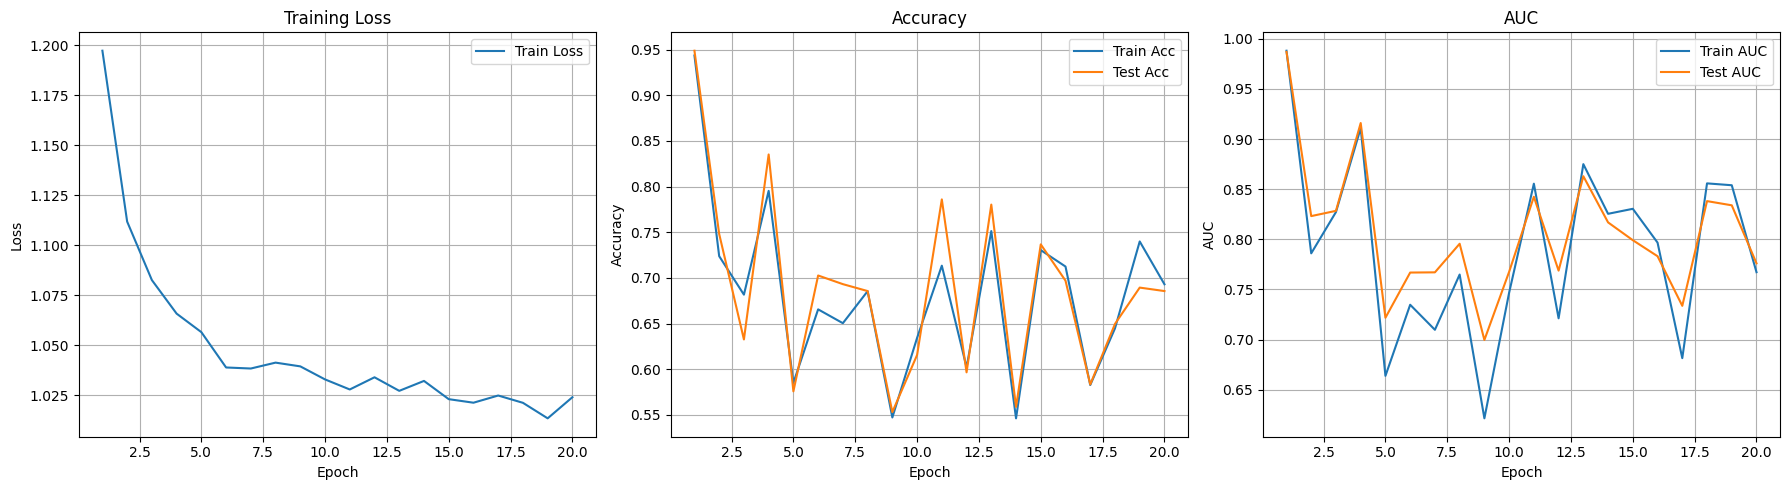

In [7]:
dataset_path = "signatures_dataset"  # adjust path if needed
train_model(dataset_path, num_epochs=20, batch_size=16, lr=0.0005)